In [85]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [86]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in this class.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## Prediction lines

In [87]:
example = r_table(0.99)
example.show(3)

x,y
0.0912047,-0.0680119
1.09128,1.04391
-1.94697,-1.88316


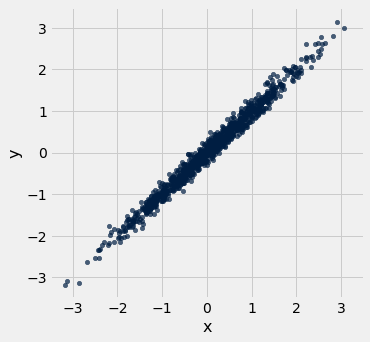

In [88]:
example.scatter('x', 'y')
resize_window()

In [89]:
def nn_prediction_example(x_val, how_close=0.25):
    """
    Predicts y-value for x based on the example table, 
    using points within the specified number of standard units
    """
    neighbors = example.where(
        'x', 
        are.between(x_val - how_close, x_val + how_close)
    )
    return np.mean(neighbors.column('y'))
    

In [90]:
nn_prediction_example(-0.5)

-0.49270067236058596

In [91]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

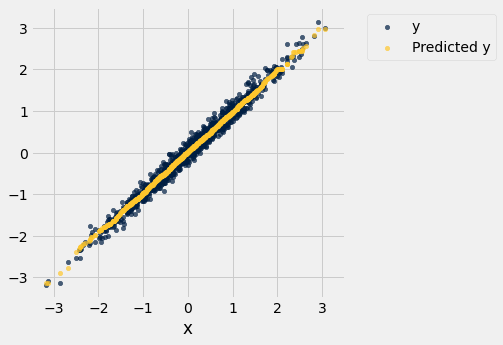

In [92]:
example.scatter('x')
resize_window()

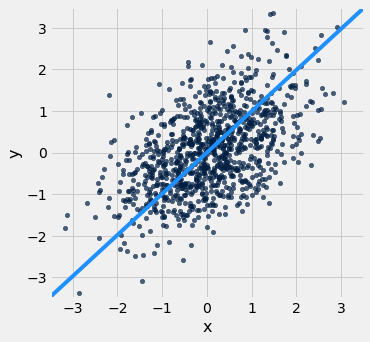

In [115]:
example.scatter('x')
draw_line(slope=0.99, color='dodgerblue')
resize_window()

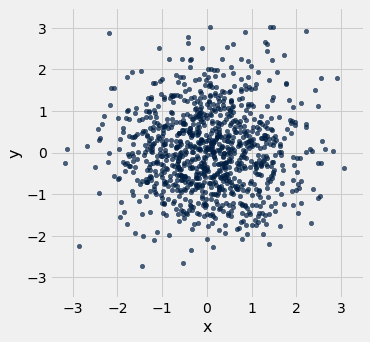

In [94]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [95]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

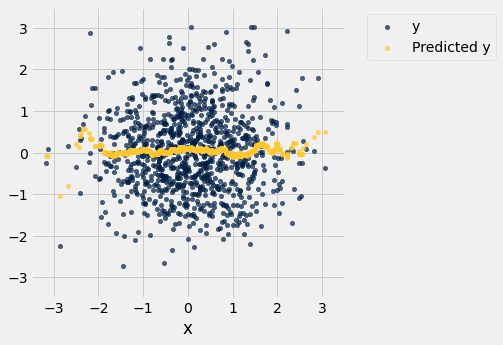

In [96]:
example = example.with_column(
    'Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
#draw_line(slope = 0)
resize_window()

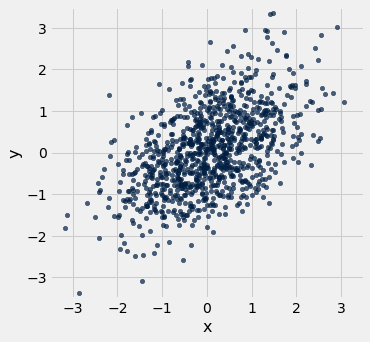

In [97]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

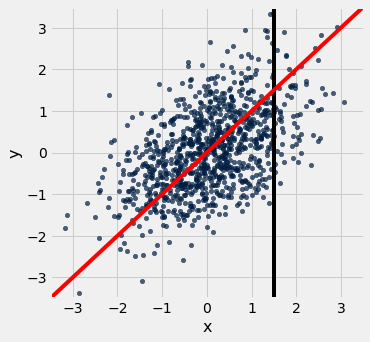

In [98]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0)

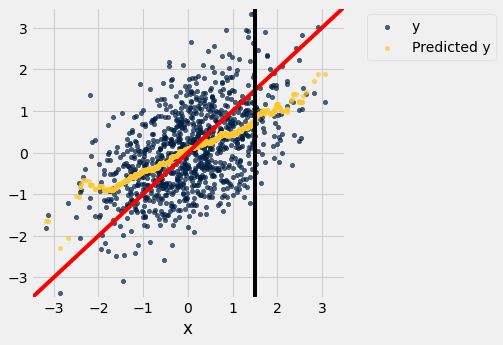

In [99]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1)
draw_vertical_line(1.5)
resize_window()

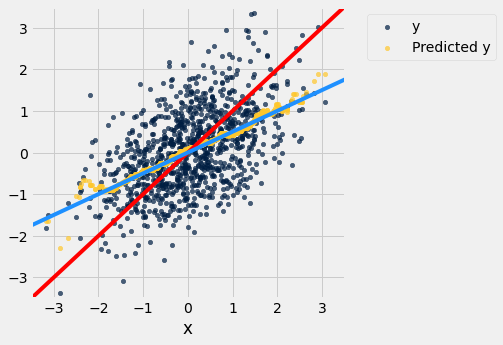

In [100]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0, color='dodgerblue')
resize_window()

## Linear regression: defining the line

In [101]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)


In [102]:
# Hint: see slide 14 of today's lecture for how to define these.
def slope(t, x, y):
    '''Computes the slope of regression line, like correlation above'''
    r = correlation(t,x,y)
    x_sd = np.std(t.column(x))
    y_sd = np.std(t.column(y))
    return r* y_sd / x_sd

    
def intercept(t, x, y):
    '''Computes the intercept of the regression line, like slope above'''
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t,x,y,)*x_mean

In [103]:
example = r_table(0.5)
slope(example, 'x', 'y')

0.5022638281625915

## Galton height data

In [104]:
galton = Table.read_table('data/galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight'))
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


In [105]:
m = galton.where('gender', 'female')
np.mean(m.column('childHeight'))
np.mean(m.column('mother'))

64.14878587196468

In [106]:
def nn_prediction_galton(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights.where(
        'MidParent', are.between(h - 0.5, h + 0.5))
    return np.mean(neighbors.column('Child'))

In [107]:
def nn_prediction_galton_su(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights_with_predictions.where(
        'MidParent in Standard Units', are.between(h - 0.25, h + 0.25))
    return np.mean(neighbors.column('Child in Standard Units'))

In [108]:
heights_with_predictions = heights.with_column(
    'Average neighbor prediction', 
    heights.apply(nn_prediction_galton, 'MidParent'))

In [109]:
galton_slope = slope(heights, 'MidParent', 'Child')
galton_intercept = intercept(heights, 'MidParent', 'Child')
galton_slope, galton_intercept

(0.637360896969479, 22.63624054958975)

In [110]:
heights.take(123)

MidParent,Child
69.48,71.5


Let's make a prediction for the height of these parents' children.


In [111]:
heights_with_predictions.where('MidParent', are.equal_to(69.48))

MidParent,Child,Average neighbor prediction
69.48,64,66.7588
69.48,74,66.7588
69.48,72,66.7588
69.48,69,66.7588
69.48,67.5,66.7588
69.48,63.5,66.7588
69.48,72,66.7588
69.48,71.5,66.7588
69.48,71.5,66.7588
69.48,70,66.7588


In [112]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', 
    galton_slope*(heights.column('MidParent')) + galton_intercept
)
heights_with_predictions

MidParent,Child,Average neighbor prediction,Regression Prediction
75.43,73.2,70.1,70.7124
75.43,69.2,70.1,70.7124
75.43,69,70.1,70.7124
75.43,69,70.1,70.7124
73.66,73.5,70.4158,69.5842
73.66,72.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
72.06,71,68.5025,68.5645
72.06,68,68.5025,68.5645


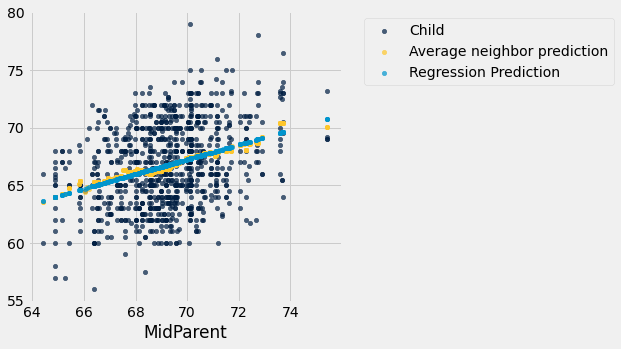

In [113]:
heights_with_predictions.scatter('MidParent')

In [117]:
# convert midparent and child to standard units
midparent_standard_units = standard_units(heights_with_predictions.column('MidParent'))
child_standard_units = standard_units(heights_with_predictions.column('Child'))

heights_with_predictions = heights_with_predictions.with_columns(
    'MidParent in Standard Units', midparent_standard_units,
    'Child in Standard Units', child_standard_units,
    
)
heights_with_predictions
average_neighbor_prediction_su = heights_with_predictions.apply(nn_prediction_galton_su, 'MidParent in Standard Units')
heights_with_predictions = heights_with_predictions.with_columns(
    'Average Neighbor Predictions SU', average_neighbor_prediction_su)
heights_with_predictions

MidParent,Child,Average neighbor prediction,Regression Prediction,MidParent in Standard Units,Child in Standard Units,Average Neighbor Predictions SU
75.43,73.2,70.1,70.7124,3.45465,1.80416,0.937589
75.43,69.2,70.1,70.7124,3.45465,0.686005,0.937589
75.43,69,70.1,70.7124,3.45465,0.630097,0.937589
75.43,69,70.1,70.7124,3.45465,0.630097,0.937589
73.66,73.5,70.4158,69.5842,2.47209,1.88802,1.02586
73.66,72.5,70.4158,69.5842,2.47209,1.60848,1.02586
73.66,65.5,70.4158,69.5842,2.47209,-0.348285,1.02586
73.66,65.5,70.4158,69.5842,2.47209,-0.348285,1.02586
72.06,71,68.5025,68.5645,1.58389,1.18917,0.502051
72.06,68,68.5025,68.5645,1.58389,0.350559,0.502051


In [118]:
galton_slope_su = slope(heights_with_predictions, 'MidParent in Standard Units', 'Child in Standard Units')
galton_intercept_su = intercept(heights_with_predictions, 'MidParent in Standard Units', 'Child in Standard Units')
galton_slope_su, galton_intercept_su



(0.32094989606395935, 2.3885585904464367e-15)

In [119]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction SU', 
    galton_slope_su*(heights_with_predictions.column('MidParent in Standard Units')) + galton_intercept_su
)
heights_with_predictions

MidParent,Child,Average neighbor prediction,Regression Prediction,MidParent in Standard Units,Child in Standard Units,Average Neighbor Predictions SU,Regression Prediction SU
75.43,73.2,70.1,70.7124,3.45465,1.80416,0.937589,1.10877
75.43,69.2,70.1,70.7124,3.45465,0.686005,0.937589,1.10877
75.43,69,70.1,70.7124,3.45465,0.630097,0.937589,1.10877
75.43,69,70.1,70.7124,3.45465,0.630097,0.937589,1.10877
73.66,73.5,70.4158,69.5842,2.47209,1.88802,1.02586,0.793416
73.66,72.5,70.4158,69.5842,2.47209,1.60848,1.02586,0.793416
73.66,65.5,70.4158,69.5842,2.47209,-0.348285,1.02586,0.793416
73.66,65.5,70.4158,69.5842,2.47209,-0.348285,1.02586,0.793416
72.06,71,68.5025,68.5645,1.58389,1.18917,0.502051,0.508349
72.06,68,68.5025,68.5645,1.58389,0.350559,0.502051,0.508349


In [120]:
correlation(heights_with_predictions, 'MidParent in Standard Units', 'Child in Standard Units')

0.32094989606395935

In [121]:
heights_with_prediction_su = heights_with_predictions.drop('MidParent', 'Child', 'Average neighbor prediction', 'Regression Prediction')
heights_with_prediction_su


MidParent in Standard Units,Child in Standard Units,Average Neighbor Predictions SU,Regression Prediction SU
3.45465,1.80416,0.937589,1.10877
3.45465,0.686005,0.937589,1.10877
3.45465,0.630097,0.937589,1.10877
3.45465,0.630097,0.937589,1.10877
2.47209,1.88802,1.02586,0.793416
2.47209,1.60848,1.02586,0.793416
2.47209,-0.348285,1.02586,0.793416
2.47209,-0.348285,1.02586,0.793416
1.58389,1.18917,0.502051,0.508349
1.58389,0.350559,0.502051,0.508349


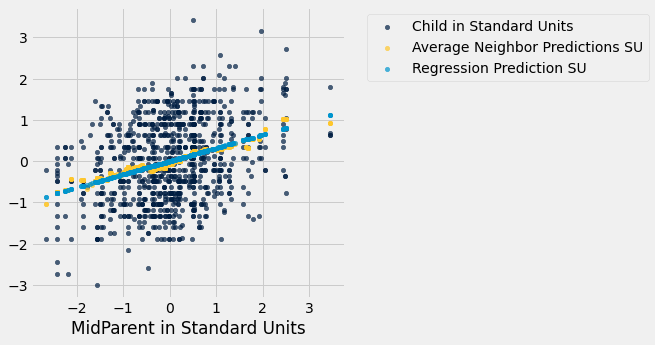

In [122]:
heights_with_prediction_su.scatter('MidParent in Standard Units')

### Regression line vs other lines

In [ ]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [ ]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [ ]:
demographics = Table.read_table('data/district_demographics2016.csv')
demographics.show(5)

In [ ]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

In [ ]:
demographics.scatter('College%', 'Median Income')

In [ ]:
correlation(demographics, 'College%', 'Median Income')

In [ ]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

In [ ]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

In [ ]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

In [ ]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [ ]:
demographics.with_column('Error', errors)

In [ ]:
np.mean(errors)

In [ ]:
np.mean(errors ** 2) ** 0.5

In [ ]:
demographics_errors(regression_slope, regression_intercept)

In [ ]:
# takes any slope, any intercept

demographics_errors(1500, 20000)

In [ ]:
demographics_errors(-1000, 75000)

### Root Mean Square Error ###

In [ ]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

In [ ]:
show_demographics_rmse(-1000, 75000)

In [ ]:
show_demographics_rmse(1500, 20000)

In [ ]:
show_demographics_rmse(regression_slope, regression_intercept)

### Numerical Optimization ###

In [ ]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [ ]:
def f(x):
    return ((x-2)**2) + 3

In [ ]:
minimize(f)

In [ ]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [ ]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [ ]:
minimize(complicated_function)

### Minimizing RMSE ###

In [ ]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [ ]:
demographics_rmse(1500, 20000)

In [ ]:
demographics_rmse(-1000, 75000)

In [ ]:
minimize(demographics_rmse)

In [ ]:
make_array(regression_slope, regression_intercept)

### Nonlinear Regression ###

In [ ]:
shotput = Table.read_table('data/shotput.csv')
shotput

In [ ]:
shotput.scatter('Weight Lifted')

In [ ]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [ ]:
best_line = minimize(shotput_linear_rmse)
best_line

In [ ]:
weights = shotput.column(0)

In [ ]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [ ]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [ ]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

In [ ]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

In [ ]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

In [ ]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)